In [1]:
# Just comment and uncomment as necessary
# The output is kinda annoying and crowded
# Install packages
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install tensorflow


In [2]:
# Imports
import numpy as np
import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt


In [3]:
############## Magic Constants ################
# Filename settings
FILE_PREFIX = "./data/"
train_filename = FILE_PREFIX + "train.csv"
test_filename = FILE_PREFIX + "test.csv"

# Scrap me: test.csv doesn't include the transported column! Should always be false
# Set to False if we want to only train and test on the train csv
loadSeparateTestCsv = False

# Set to true when we want to generate a submission for kaggle
testSubmission = False

# Common utility functions
def checkNotSubmitting():
    assert not testSubmission, "Don't run this cell if creating a submission"
################################################

In [4]:

# We might want to mount a shared google drive so we don't have to reupload
# everytime the session expires
trainData = pd.read_csv(train_filename)
data = None
testData = None
if loadSeparateTestCsv:
    testData = pd.read_csv(test_filename)
    data = pd.concat([trainData, testData])
else:
    data = trainData

if testSubmission:
    data = pd.read_csv(test_filename)

# FEATURE MODIFICATION SETTINGS
dropCols = ["PassengerId", "Name"]  # Columns to drop entirely
# Binary columns to replace with 1's and 0's
binaryCols = ["CryoSleep", "VIP", "Transported"]
# Category columns that are commonly shared, dummies are built from these
categoricalCols = []
# Ok my idea for this is that for the fairly unique columns we should generate a numerical
# id for each unique entry, then replace the column with the id. Generating dummies with these
# just leads to a feature explosion.
uniqueGeneratorCols = ["Cabin", "HomePlanet", "Destination"]
###############################

# Not sure why these features have NaN's, but we can (safely?) replace them with 0's.
data["CryoSleep"] = data["CryoSleep"].fillna(value=False)
data["VIP"] = data["VIP"].fillna(value=False)
data["VRDeck"] = data["VRDeck"].fillna(value=0)
data["ShoppingMall"] = data["ShoppingMall"].fillna(value=0)
data["RoomService"] = data["RoomService"].fillna(value=0)
data["FoodCourt"] = data["FoodCourt"].fillna(value=0)
data["Spa"] = data["Spa"].fillna(value=0)
# weird ones
data["Cabin"] = data["Cabin"].fillna(value="UNKNOWN")
data["HomePlanet"] = data["HomePlanet"].fillna(value="UNKNOWN")
data["Destination"] = data["Destination"].fillna(value="UNKNOWN")
data["Age"] = data["Age"].fillna(value=-1)

# test.csv doesn't have the transported column
if testSubmission and "Transported" in binaryCols:
    binaryCols.remove("Transported")
# We want to keep the passengerIds for submission
if testSubmission and "PassengerId" in dropCols:
    dropCols.remove("PassengerId")

data = data.drop(columns=dropCols)
for c in binaryCols:
    data[c] = data[c].astype(int)
data = pd.get_dummies(data, columns=categoricalCols)
# Generate unique ids per column
for c in uniqueGeneratorCols:
    data[c] = data[c].astype("category").cat.rename_categories(
        range(data[c].nunique()))

# We don't want any nan data
assert (not data.isnull().values.any())

yCol = "Transported"
X, y = None, None
if not testSubmission:
    X = data.drop(columns=yCol)
    y = data[yCol]
else:
    X = data

X_train, X_test, y_train, y_test = None, None, None, None
if not testSubmission:
    if testData is None:
        X_train, X_test, y_train, y_test = train_test_split(X, y)
    else:
        X_train = X[: trainData.shape[0]]
        X_test = X[trainData.shape[0]:]
        y_train = y[: trainData.shape[0]]
        y_test = y[trainData.shape[0]:]
else:
    X_test = X

# print(data.head())
# print(data.describe())


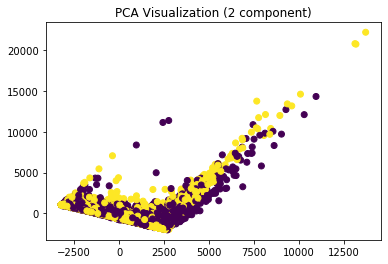

In [5]:
# Data visualization
# tSNE or PCA here

checkNotSubmitting()

pcaComps = 2
pca = PCA(n_components=pcaComps)
pca_train = pca.fit_transform(X_train, y_train)
pca_test = pca.transform(X_test)

if pcaComps == 2:
    plt.scatter(pca_train[:, 0], pca_train[:, 1], c=y_train)
plt.title(f"PCA Visualization ({pcaComps} component)")
plt.show()

# Feature importance graphing
# todo
estimators = 100  # todo: grid search me!
#gbc = GradientBoostingClassifier(n_estimators=100)
#gbc.fit(X_train, y_train)
# todo: render the important features
# look at my roommates code here: https://github.com/justincdavis/BowlGamesNN/blob/main/CFBowlGamesNN.ipynb


In [6]:
# Feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error

checkNotSubmitting()

### Notes ###
# Justin: This references homework 4a_FL_Feature_Selection.ipynb

# Create a StandardScalar to standardize the passenger features
scalar = sk.preprocessing.StandardScaler().fit(X=X_train)
# Don't want to change the original values
XT_train = scalar.transform(X=X_train)
XT_test = scalar.transform(X=X_test)

# Create set of models to estimate on
# TODO: Figure out more models?
model_estimators = [KNeighborsClassifier, GaussianNB]


In [7]:
print(f"---------------------------------Mutual Information-------------------------------------")

# Select the best features based on mutual information score from the training data,
#  then transform XT_train and XT_test into the new subset of selected features
for model in model_estimators:
    # Set up tracker variables
    best_k_MI = 0
    best_k_test = 0
    best_predictions_MI = np.zeros(1)
    best_predictions_test = np.zeros(1)
    lowest_mse_MI = 1
    lowest_mse_test = 1

    max_k = 11
    for k in range(1, max_k):
        mutual_information_transformer = sk.feature_selection.SelectKBest(
            score_func=sk.feature_selection.mutual_info_regression,
            k=k
        ).fit(X=XT_train, y=y_train)
        MI_X_train = mutual_information_transformer.transform(X=XT_train)
        MI_X_test = mutual_information_transformer.transform(X=XT_test)

        # Print out the mutual informations
        # Note:
        #   Just commenting this out because it's crowds the terminal
        #       Looks like this works, but I'm worried about using data.columns
        # for feature, importance in zip(data.columns, mutual_information_transformer.scores_):
        #     print(f"The MI score for {feature} is {importance}")

        # Create model and estimate
        miEst = model().fit(X=MI_X_train, y=y_train)
        train_predictions = miEst.predict(X=MI_X_train)
        test_predictions = miEst.predict(X=MI_X_test)

        mse_MI = mean_squared_error(y_true=y_train, y_pred=train_predictions)
        mse_test = mean_squared_error(y_true=y_test, y_pred=test_predictions)
        if (mse_MI < lowest_mse_MI):
            best_k_MI = k
            lowest_mse_MI = mse_MI
            best_predictions_MI = train_predictions
        if (mse_test < lowest_mse_test):
            best_k_test = k
            lowest_mse_test = mse_test
            best_predictions_test = test_predictions

        # Note:
        #   uncomment if you want to see the individual mutual information scores
        # print(f"The mean squared error when training on the MI selected features is {mse_MI}.")
        # print(f"When testing on the test data, the mean squared error is {mse}\n")

    print(f"Model: {model}")
    print(
        f"The lowest MSE for the MI selected features is {lowest_mse_MI} with k = {best_k_MI}")
    print(
        f"The f1 score is {f1_score(y_train, best_predictions_MI, average='weighted')}\n")
    print(
        f"The lowest MSE for on the test data is {lowest_mse_test} with k = {best_k_test}")
    print(
        f"The f1 score is {f1_score(y_test, best_predictions_test, average='weighted')}\n")


---------------------------------Mutual Information-------------------------------------
Model: <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
The lowest MSE for the MI selected features is 0.16428900138057984 with k = 10
The f1 score is 0.835711462529341

The lowest MSE for on the test data is 0.22171113155473782 with k = 9
The f1 score is 0.7782986259244788

Model: <class 'sklearn.naive_bayes.GaussianNB'>
The lowest MSE for the MI selected features is 0.2817916858413867 with k = 1
The f1 score is 0.7117190620162526

The lowest MSE for on the test data is 0.27598896044158233 with k = 9
The f1 score is 0.7111066527403574



In [12]:
# 2c_SL _SVM_Kernel.ipynb
# Testing the SVM Kernel to see if it performs better than KNN or Naive Bayes

params = {
    "kernel": ["linear", "poly"],
    "degree": [1, 2, 3],
    "C": [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4],
    "random_state": [0],
    "gamma": ["auto"]
}
clf = GridSearchCV(estimator=SVC(), param_grid=params,
                   scoring="f1_weighted", cv=10, n_jobs=-1)

clf.fit(X=X_train, y=y_train)
print(f"The best estimator is {clf.best_estimator_}")
print(f"Best score on training data: {clf.best_score_}")

testScore = clf.score(X=X_test, y=y_test)
print(f"Best score on testing data: {testScore}")


In [ ]:

print(f"---------------------------------Recursive Elimination----------------------------------")

for model in model_estimators:
    lowest_mse_rfe = 1
    lowest_mse_test = 1
    best_step_rfe = 0
    best_step_test = 0
    best_predictions_rfe = np.zeros(1)
    best_predictions_test = np.zeros(1)
    most_important_rfe = list()
    most_important_test = list()

    # Use recursive feature elimination (RFE) object to determine the k features to select
    # from X_train using a variable step size
    max_steps = 11
    for step in range(1, 11):
        rfe_transformer = sk.feature_selection.RFE(
            estimator=rfeEst, step=step).fit(X=XT_train, y=y_train)
        rfe_X_train = rfe_transformer.transform(X=XT_train)
        rfe_X_test = rfe_transformer.transform(X=XT_test)

        rfeEst = model().fit(rfe_X_train, y_train)
        train_predictions = miEst.predict(X=rfe_X_train)
        test_predictions = miEst.predict(X=rfe_X_test)

        mse_rfe = mean_squared_error(y_true=y_train, y_pred=train_predictions)
        mse_test = mean_squared_error(y_true=y_test, y_pred=test_predictions)

        if (mse_rfe < lowest_mse_rfe):
            best_step_rfe = step
            lowest_mse_rfe = mse_rfe
            best_predictions_rfe = train_predictions
            most_important_rfe = list(
                data.coloumns[:11][rfe_transformer.support_])
        if (mse_test < lowest_mse_test):
            best_k_test = k
            lowest_mse_test = mse_test
            best_predictions_test = test_predictions
            most_important_test = list(
                data.coloumns[:11][rfe_transformer.support_])

        # Note:
        #   Uncomment to see individual mse scores and features
        # print(
        #     f"The mean squared error when training on the RFE selected features is {mean_squared_error(y_train, rfeEst.predict(rfe_X_train))}.")
        # print(
        #     f"\nWhen testing on the test data, the mean squared error is {mean_squared_error(y_test, rfeEst.predict(rfe_X_test))}")
        # print(
        #     f"The most important features as determined by RFE were {list(data.columns[:11][rfe_transformer.support_])}")

    print(f"Model: {model}")
    print(
        f"The lowest MSE for the RFE selected features is {lowest_mse_rfe} with step = {best_step_rfe}")
    print(
        f"The f1 score is {f1_score(y_train, best_predictions_rfe, average='weighted')}\n")
    print(
        f"The most important features as determined by RFE were {list(data.columns[:11][rfe_transformer.support_])}")
    print(
        f"The lowest MSE for on the test data is {lowest_mse_test} with step = {best_step_test}")
    print(
        f"The f1 score is {f1_score(y_test, best_predictions_test, average='weighted')}\n")


In [ ]:
print(f"---------------------------------Lasso Embedded Method----------------------------------")
max_alphas = 1001
best_alpha_lasso = 0
best_alpha_test = 0
lowest_mse_lasso = 1
lowest_mse_test = 1
best_predictions_lasso = np.zeros(1)
best_predictions_test = np.zeros(1)

for alpha in range(10, max_alphas, 10):
    lassoEst = sk.linear_model.LassoCV(
        n_alphas=alpha, n_jobs=-1).fit(X=XT_train, y=y_train)
    # for feature, coef in zip(data.columns, lassoEst.coef_):
    #     print(
    #         f"The magniture of the feature coefficient for {feature} is {abs(coef)}.")

    train_predictions = lassoEst.predict(XT_train)
    test_predictions = lassoEst.predict(XT_test)

    mse_lasso = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_train, test_predictions)
    if (mse_lasso < lowest_mse_lasso):
        lowest_mse_lasso = mse_lasso
        best_alpha_lasso = 0
        best_predictions_lasso = train_predictions
    if (mse_test < lowest_mse_test):
        lowest_mse_test = mse_test
        best_alpha_test = 0
        best_predictions_test = test_predictions

    # print(
    #     f"\nThe mean squared error when training using lasso is {mse_lasso}.")
    # print(
    #     f"When testing on the test data, the mean squared error is {mse_test}")

print(
    f"\nThe best mean squared error when training using lasso is {lowest_mse_lasso} with an alpha of {best_alpha_lasso}.")
print(
    f"The f1 score is {f1_score(y_test, best_predictions_train, average='weighted')}\n")
print(
    f"\nThe best mean squared error on the test data is {lowest_mse_test} with an alpha of {best_alpha_test}.")
print(
    f"The f1 score is {f1_score(y_test, best_predictions_test, average='weighted')}\n")


In [ ]:
# Feature extraction

from sklearn.metrics import f1_score
from sklearn.svm import LinearSVC
from sklearn.manifold import SpectralEmbedding

checkNotSubmitting()


In [ ]:
# Justin: This is copied from 4b_FL_Feature_Extraction.ipynb
#         We can toy around to make it better, but this is a start

spectral_transformer = SpectralEmbedding().fit(X=X_train, y=y_train)
spectral_embedding = spectral_transformer.embedding_
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=y_train)
plt.title("Spectral Embedding")
plt.show()

X_complete = pd.concat([X_train, X_test])
size_Xtrain = len(X_train)

spectral_model = SpectralEmbedding()
spectral_train = spectral_model.fit_transform(
    X=X_complete[:size_Xtrain], y=y_train
)
spectral_test = spectral_model.fit_transform(
    X=X_complete[size_Xtrain:], y=y_test
)

spectral_svc = LinearSVC().fit(X=spectral_train, y=y_train)
print(
    f"The Spectral Embedding + Linear SVM scores an F-1 = {f1_score(y_test, spectral_svc.predict(spectral_test)):.3f}.")


In [ ]:
# Now we have the reduced dataset with high mutual information between each feature, time to run some models


In [ ]:
# knn or svm?

checkNotSubmitting()


In [ ]:
# Neural network

# Model parameters
activation = "sigmoid"
outputActivation = "sigmoid"  # This should not change
hiddenExpansionSize = 50
denseHiddenLayers = 3
autoencoderCompressionSize = 6
##################

# Andrew's model arch notes:
# - do we progressively collapse when autoencoding or dense map straight to it?
# - mess around with dropout layers to reduce overfitting

checkNotSubmitting()

layers = []
layers.append(tf.keras.layers.Dense(hiddenExpansionSize, input_shape=(
    X.shape[1],), activation=activation, name=f"input_{X.shape[1]}x1"))
for i in range(denseHiddenLayers):
    layers.append(tf.keras.layers.Dense(hiddenExpansionSize,
                  activation=activation, name=f"dense_{i}"))
layers.append(tf.keras.layers.Dense(autoencoderCompressionSize,
              activation=activation, name="autoenc"))
layers.append(tf.keras.layers.Dense(
    2, activation=outputActivation, name="output"))

dnn = tf.keras.Sequential(layers)
dnn.build()
dnn.summary()

nnDefaultWeights = dnn.get_weights()


In [ ]:
# Neural network compilation and training

# TRAINING PARAMETERS
learningRate = 0.001
#lossFunc = "binary_crossentropy"
lossFunc = "mae"
epochs = 30
batchSize = 1000
#####################

if not testSubmission:
    optimizer = tf.keras.optimizers.Adam(learning_rate=learningRate)
    #optimizer = tf.keras.optimizers.SGD()

    dnn.compile(optimizer, loss=lossFunc, metrics=["accuracy"])

    dnn.set_weights(nnDefaultWeights)  # Reset if we already fit
    dnn.fit(X_train, y_train, batch_size=batchSize, epochs=epochs)

    nnMetrics = dnn.evaluate(X_test, y_test)
    print(f"NN evaluated accuracy: {nnMetrics}")
else:
    predictions = dnn.predict(X_test.drop(
        columns=["PassengerId"]), batch_size=batchSize)
    # We have 2 output nodes, we want to take the index of the node with greater activation
    predictionsBinary = np.argmax(predictions, axis=1)
    predictionsBinary = 1 - predictionsBinary  # Invert the result
    outData = pd.DataFrame()
    outData["PassengerId"] = X_test["PassengerId"]
    outData["Transported"] = predictionsBinary.astype(bool)
    outData.to_csv("results.csv", index=False)
